####**Installing PySpark, Hadoop And Necessary Libraries**

## **Done By**

## **CS20B1057 A S V Dhanush**

## **ASBD PROJECT**

## **PROJECT NAME: MARKET BASKET ANALYSIS AND CLUSTERING USING PYSPARK**

## DATASETS USED: Groceries data.csv & basket.csv

In [1]:
!pip install pyspark
!pip install pyspark_dist_explore # Used for a histogram

In [2]:
!pip install deap
!pip install -q findspark
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


##**Importing libraries**

In [3]:
from pyspark import SparkContext
from pyspark.sql import functions as f, SparkSession, Column
import findspark
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from deap import base, creator, tools
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

## **Creating a PySpark session**

In [4]:
# Create a spark session. All sorts of settings can be specified here.
spark = SparkSession.builder.appName("ASBD_PROJECT").getOrCreate()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####**Taking the csv files in a Spark dataframe for EDA**

In [6]:
df = spark.read.csv("basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df_all = spark.read.csv("Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Show is pyspark's version of head(), although it can be slow so I do try to skip this.
df.show(5)
df_all.show(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  1|
|       soda|pickled vegetables|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  2|
|canned beer|   misc. beverages|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  3|
|    sausage|  hygiene articles|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_n

###**Exploratory Data Analysis (EDA)**

In [8]:
df_basket  =pd.read_csv("basket.csv")
df_groceries = pd.read_csv("Groceries data.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df_basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_groceries.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


####**Checking for the types of each column**

In [11]:
df_basket.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
dtype: object

In [12]:
df_groceries.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Member_number       int64
Date               object
itemDescription    object
year                int64
month               int64
day                 int64
day_of_week         int64
dtype: object

####**For Descriptive Statistics**

In [13]:
# Generate descriptive statistics
df_basket.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10
count,14963,14963,4883,2185,795,451,276,196,51,1,1
unique,165,165,154,146,126,101,88,72,35,1,1
top,whole milk,whole milk,whole milk,whole milk,whole milk,shopping bags,yogurt,whole milk,shopping bags,curd,newspapers
freq,1083,983,244,111,39,25,19,14,4,1,1


In [14]:
df_groceries.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


####**Plotting Different graphical visualisations**

####**Pie - Plot**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


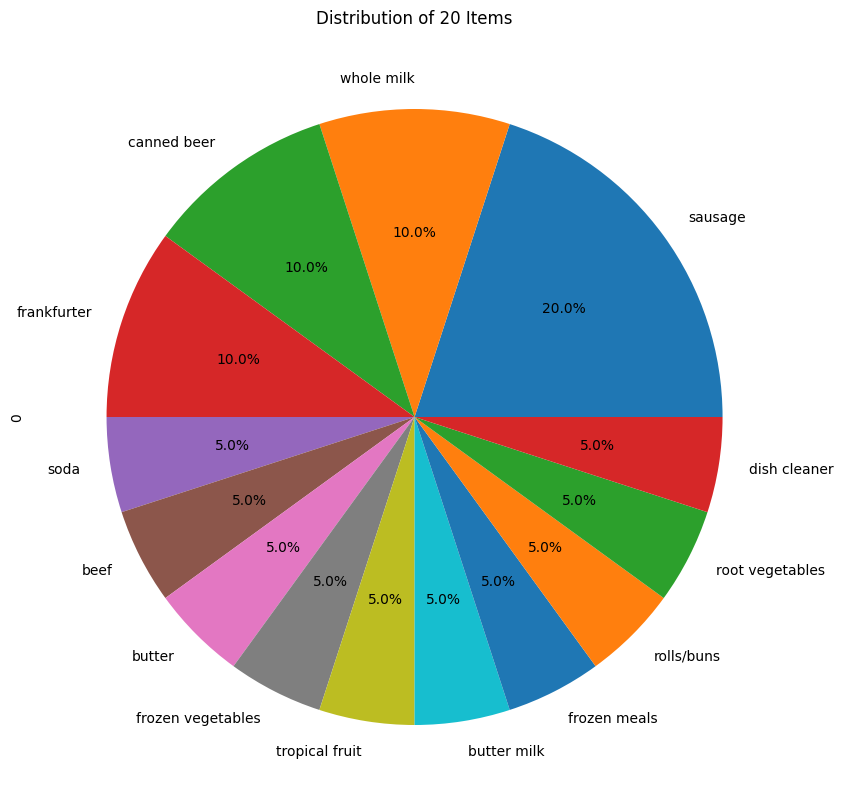

In [15]:
# Aggregate data
item_counts = df_basket['0'][:20].value_counts()

# Create pie chart
item_counts.plot.pie(autopct='%1.1f%%', figsize=(10, 10))
plt.title('Distribution of 20 Items')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


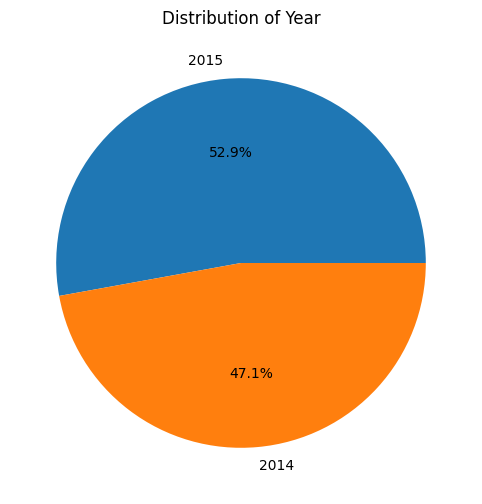

In [16]:
category_counts = df_groceries['year'].value_counts()

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Year')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


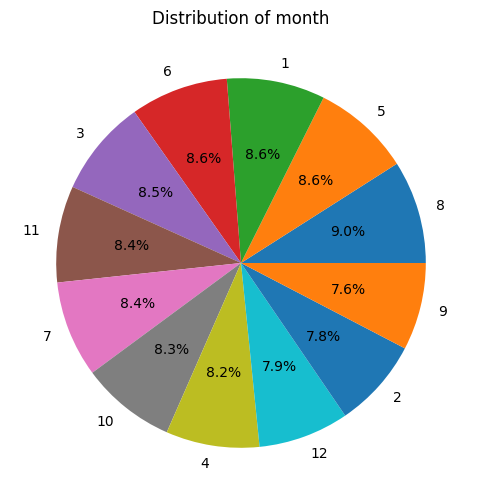

In [17]:
category_counts = df_groceries['month'].value_counts()

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of month')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


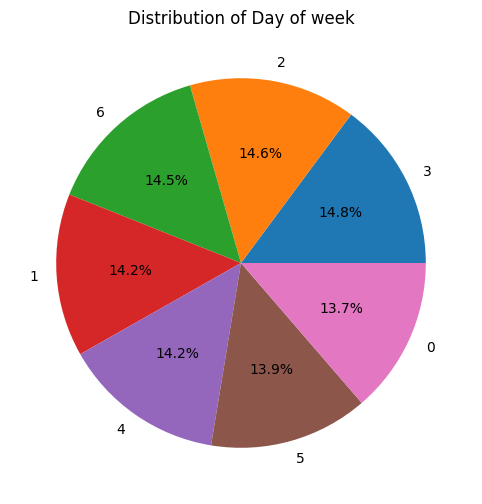

In [18]:
category_counts = df_groceries['day_of_week'].value_counts()

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Day of week')
plt.show()

####**Number of items bought each day of the week**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


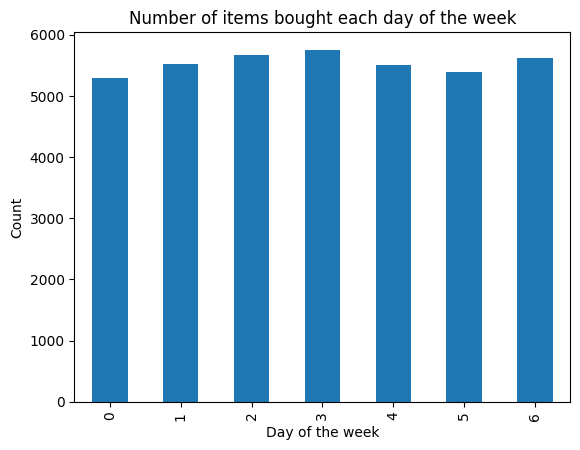

In [19]:
df_groceries['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of items bought each day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.show()


####**Scatter Plots**

####**Number of items bought each day**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


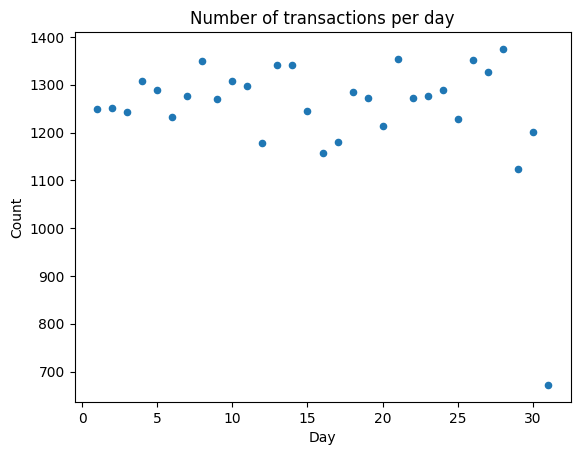

In [20]:

# Scatter plot for the number of items bought each day of the month in the groceries dataset
day_counts = df_groceries['day'].value_counts().sort_index().reset_index()
day_counts.columns = ['day', 'count']
day_counts.plot(kind='scatter', x='day', y='count')
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Number of transactions per day')
plt.show()



##**Number of items bought each day of the month**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-21-c159a115a844>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_groceries['month'], kde=True)


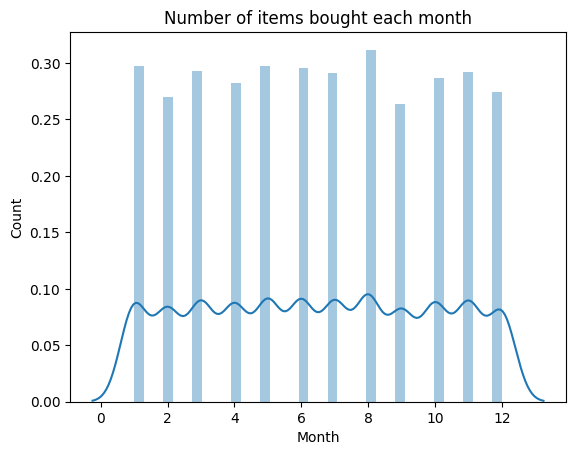

In [21]:
# Dist plot for the number of items bought each month in the groceries dataset
sns.distplot(df_groceries['month'], kde=True)
plt.title('Number of items bought each month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


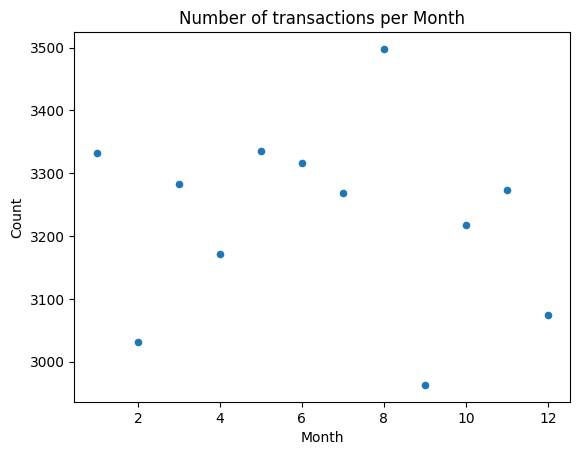

In [22]:

# Scatter plot for the number of items bought each day of the month in the groceries dataset
month_counts = df_groceries['month'].value_counts().sort_index().reset_index()
month_counts.columns = ['month', 'count']
month_counts.plot(kind='scatter', x='month', y='count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of transactions per Month')
plt.show()


####**Dist Plot**

**Number of items bought each year**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-23577b17b1f6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_groceries['year'], kde=True)


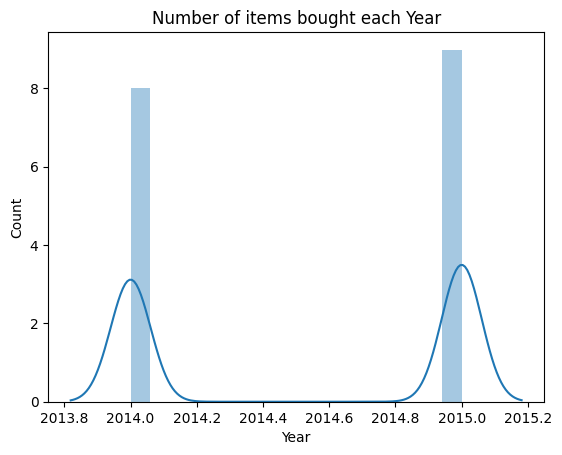

In [23]:
# Dist plot for the number of items bought each month in the groceries dataset
sns.distplot(df_groceries['year'], kde=True)
plt.title('Number of items bought each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


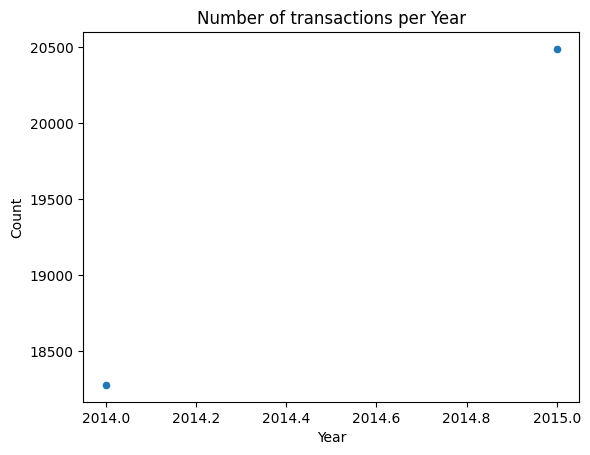

In [24]:

# Scatter plot for the number of items bought each day of the month in the groceries dataset
year_counts = df_groceries['year'].value_counts().sort_index().reset_index()
year_counts.columns = ['year', 'count']
year_counts.plot(kind='scatter', x='year', y='count')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of transactions per Year')
plt.show()


##**Showing the structure of the Spark dataframe**


In [25]:
# printSchema() shows the structure of the dataframe. This is important for debugging.
df.printSchema()
df_all.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- 6: string (nullable = true)
 |-- 7: string (nullable = true)
 |-- 8: string (nullable = true)
 |-- 9: string (nullable = true)
 |-- 10: string (nullable = true)
 |-- id: long (nullable = false)

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- id: long (nullable = false)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###**10 Frequent Items Bought**

In [26]:
item_counts = df_basket.stack().value_counts()
print(item_counts)


whole milk               2502
other vegetables         1898
rolls/buns               1716
soda                     1514
yogurt                   1334
                         ... 
make up remover             5
bags                        4
baby cosmetics              3
kitchen utensil             1
preservation products       1
Length: 167, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**20 Most Frequent Items**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


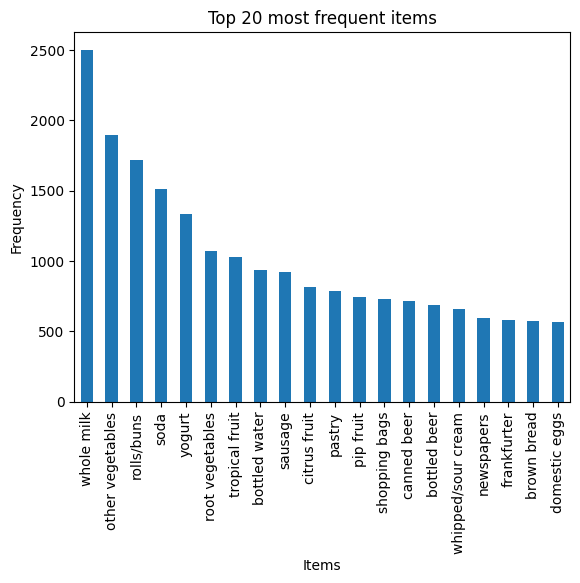

In [27]:
item_counts[:20].plot(kind='bar')
plt.title('Top 20 most frequent items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-28ab7a0727e0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(item_counts[:10], hist_kws=dict(linewidth=2, edgecolor="k"))


<Axes: ylabel='Density'>

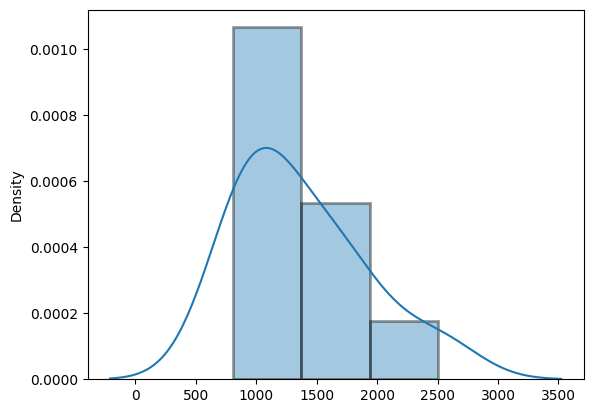

In [28]:
sns.distplot(item_counts[:10], hist_kws=dict(linewidth=2, edgecolor="k"))

###**To calculate the number of  baskets that are there per customer?**


In [29]:
num_baskets = df_all.groupBy("Member_number").count()
num_baskets.show(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



# The distribution of the number of baskets

Create a histogram of the number of baskets using pyspark_dist_explore. This library can create some fast visualizations on a pyspark dataframe, similar to matplotlib.

####**Using Histogram**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

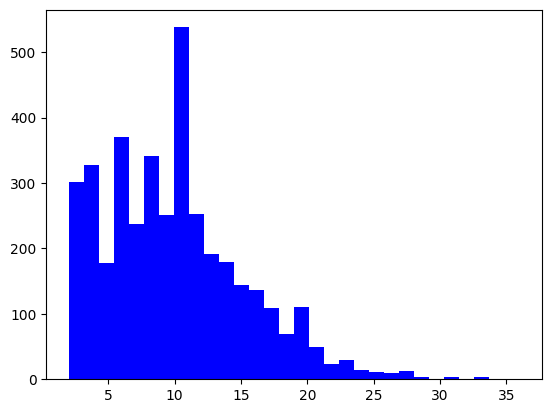

In [30]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins = 30, color=['blue'])

###**Violin Plots For Different Columns**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


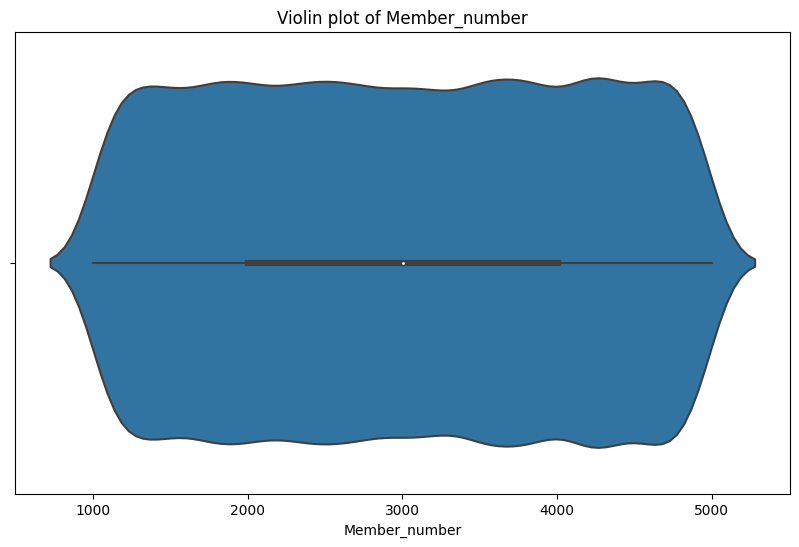

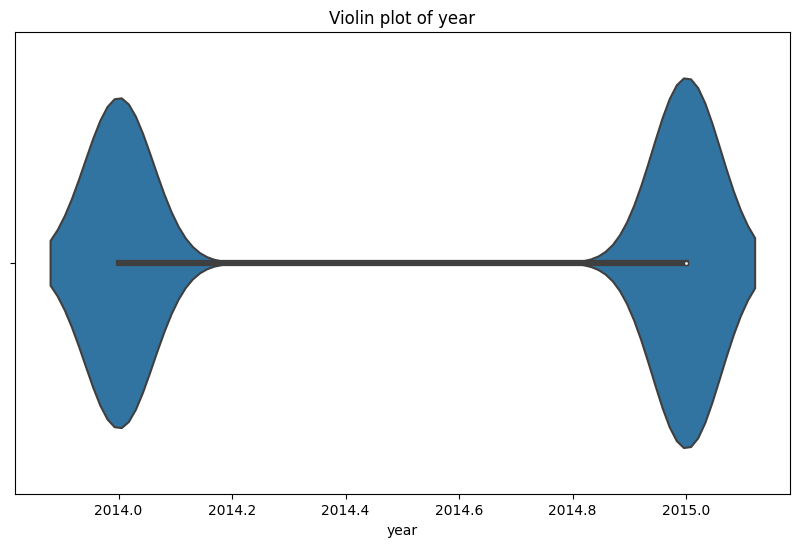

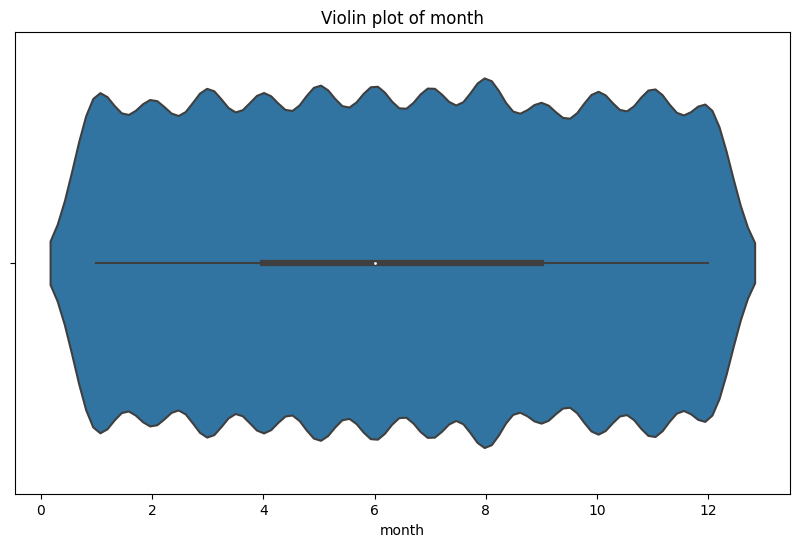

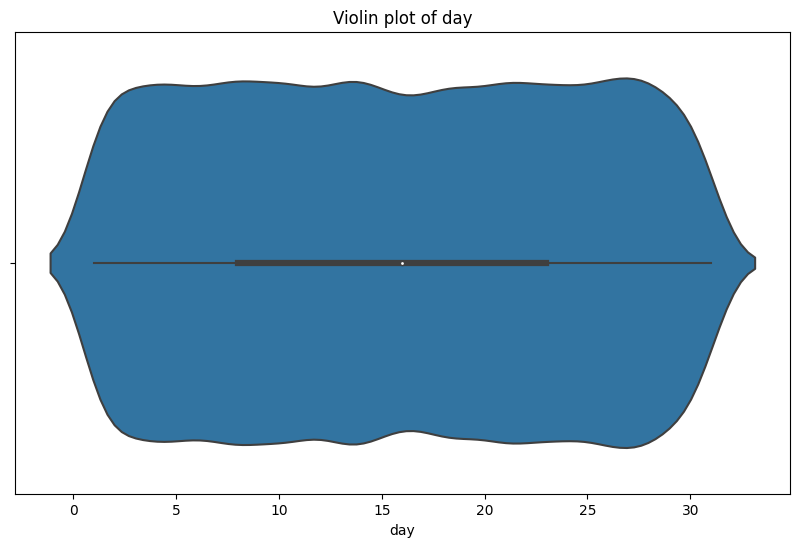

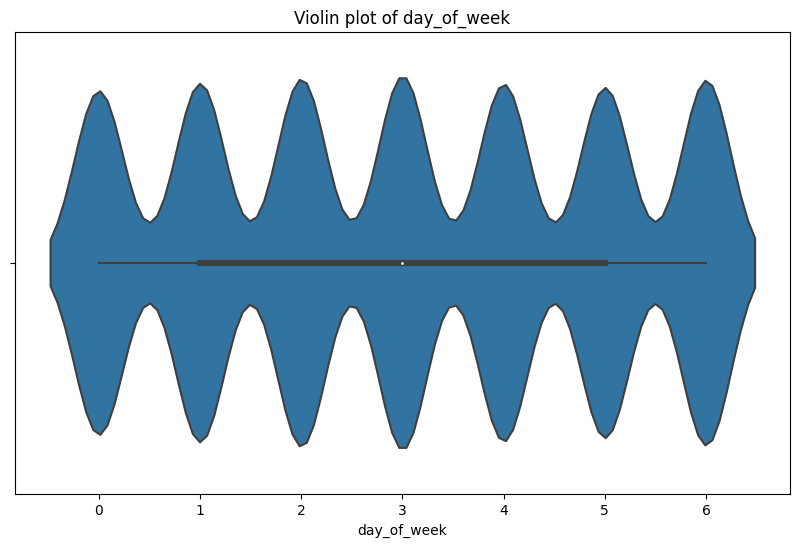

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only int columns
df_groceries_int = df_groceries.select_dtypes(include=['int'])

# Create violin plots for each int column
for col in df_groceries_int.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=df_groceries_int[col])
    plt.title(f'Violin plot of {col}')
    plt.show()

In [32]:
!pip install stemgraphic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2244373360ca4a4ea5cf4b21b33b2bd472e81033f992c4da7a9122f41878aae4
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


###**Stem Leaf Plot For Groceries Dataframe**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


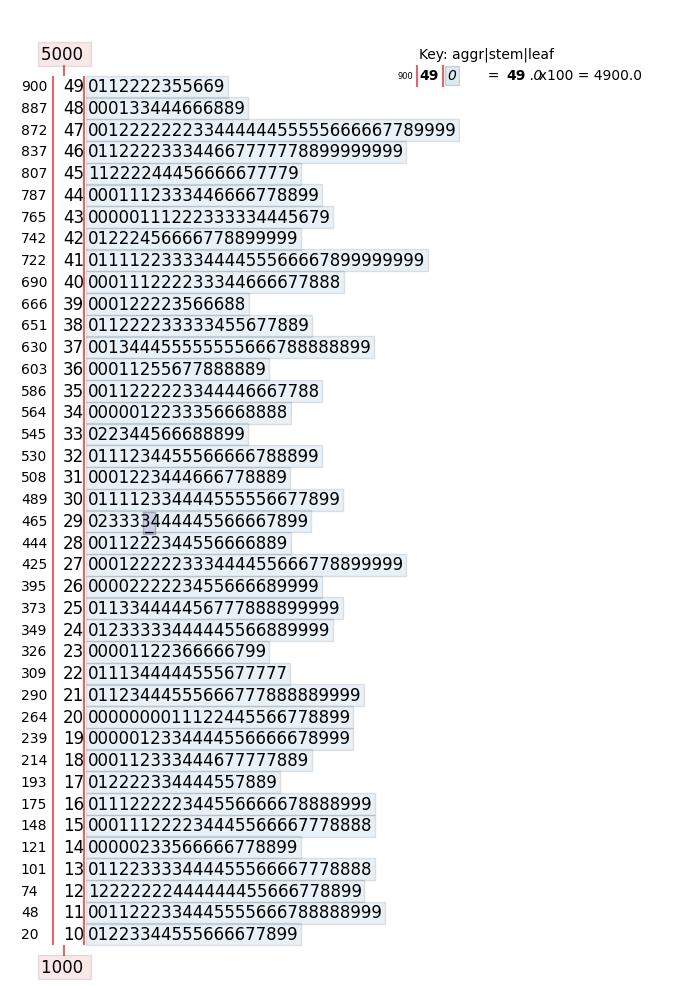

In [33]:
import stemgraphic

# Select the first numerical column from each DataFrame
groceries_col = df_groceries.select_dtypes(include=[np.number]).columns[0]
# Create stem-and-leaf plots
fig, ax = stemgraphic.stem_graphic(df_groceries[groceries_col])
plt.show()


###**Histogram Plots**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



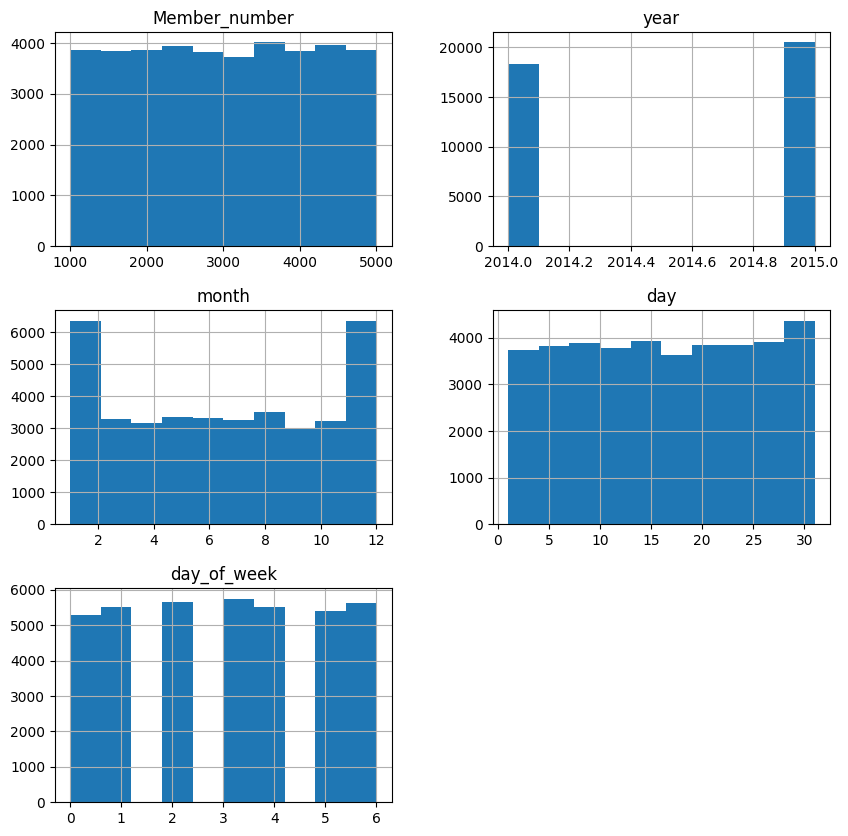

In [34]:
df_groceries.hist(figsize=(10,10))
plt.show()

##**PySpark's implementation of FPGrowth**


In [35]:
py_basket = df.select("id", f.array([df[c] for c in df.columns[:11]]).alias("basket"))
py_basket.printSchema()
# False tells show() to not truncate the columns when printing.
py_basket.show(3, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+--------------------------------------------------------------------------------------------+
|id |basket                                                                                      |
+---+--------------------------------------------------------------------------------------------+
|0  |[whole milk, pastry, salty snack, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]           |
|1  |[sausage, whole milk, semi-finished bread, yogurt, NULL, NULL, NULL, NULL, NULL, NULL, NULL]|
|2  |[soda, pickled vegetables, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]            |
+---+--------------------------------------------------------------------------------------------+
only showing top 3 rows



### There should not be any nulls in the array. Remove using array_except()

This will be the final dataframe used for FPGrowth.

In [36]:
df_aggregated = py_basket.select("id", f.array_except("basket", f.array(f.lit(None))).alias("basket"))
df_aggregated.show(3, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
+---+--------------------------------------------------+
only showing top 3 rows



## **Hyperparameters**

The hyperparameters used in FPGrowth are minimum support, minimum confidence, and number of partitions.

* minSupport - The minimum support of an item to be considered in a frequent itemset.
* minConfidence - The minimum confidence for generating an association rule from an itemset.
* numPartitions - The number of partitions used to distribute the work. This is Spark-specific.

The default number of partitions is the number of partitions for the input dataset.

In [37]:
# Run FPGrowth and fit the model.
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')

model = fp.fit(df_aggregated)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



###**FP - Growth Model Result**

In [38]:
# View a subset of the frequent itemset.
model.freqItemsets.show(10, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



+------------------------+----+
|items                   |freq|
+------------------------+----+
|[cocoa drinks]          |16  |
|[canned fruit]          |21  |
|[specialty cheese]      |72  |
|[chocolate marshmallow] |60  |
|[pet care]              |85  |
|[house keeping products]|45  |
|[jam]                   |34  |
|[light bulbs]           |29  |
|[beef]                  |508 |
|[beef, frankfurter]     |15  |
+------------------------+----+
only showing top 10 rows



###**Association Rules**

In [39]:
# Use filter to view just the association rules with the highest confidence.
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[bottled beer]       |[whole milk]|0.15781710914454278|0.9993302598941151|0.007150972398583172 |
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[ham]                |[whole milk]|0.16015625         |1.0141421789039358|0.0027400922274944863|
|[frozen fish]        |[whole milk]|0.1568627450980392 |0.9932870312746344|0.0010693042839002875|
|[sausage, whole mil

###**Creating A prediction based on the generated association rules**


In [40]:
# Create a PySpark dataframe instance
columns = ['basket']
new_data = [(['ham', 'yogurt', 'light bulbs'],), (['jam','yogurt'],)]
rdd = spark.sparkContext.parallelize(new_data)
new_df = rdd.toDF(columns)
new_df.printSchema()
new_df.show(2,False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------------+
|basket                    |
+--------------------------+
|[ham, yogurt, light bulbs]|
|[jam, yogurt]             |
+--------------------------+



#**Predicting Based On the Association Rules**


In [41]:
model.transform(new_df).show(5, False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



+--------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|basket                    |prediction                                                                                                                                                                                                                                                                                                              

##**Apriori Algorithm Implimentation**

In [42]:
df_basket_apriori = df_basket.fillna('1', inplace = False)

Transactions_apriori=[]

for i in range (14963):
    transactions_apriori = []
    for j in range(11):
        if df_basket_apriori.iloc[i,j] != '1':
            transactions_apriori.append(df_basket_apriori.iloc[i,j])
    Transactions_apriori.append(transactions_apriori)
Transactions_apriori[2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['soda', 'pickled vegetables']

In [43]:
Transactions_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['frankfurter', 'curd'],
 ['beef', 'white bread'],
 ['butter', 'whole milk'],
 ['frozen vegetables', 'other vegetables'],
 ['tropical fruit', 'sugar'],
 ['butter milk', 'specialty chocolate'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['sausage', 'rolls/buns'],
 ['dish cleaner', 'cling film/bags'],
 ['canned beer', 'frozen fish'],
 ['pip fruit', 'whole milk', 'tropical fruit'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['rolls/buns', 'red/blush wine', 'chocolate'],
 ['other vegetables', 'shopping bags'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'hygiene

####**Converting into 1s and 0s to generate a transaction database**

In [44]:
te = TransactionEncoder()
te_bin = te.fit_transform(Transactions_apriori)
Transactions_apriori = pd.DataFrame(te_bin, columns = te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [45]:
Transactions_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


###**Generating Apriori For Frequent Itemset Mining**

In [46]:
def encode(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
Transactions_apriori = Transactions_apriori.applymap(encode)
Transactions_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
frequent_items = apriori(Transactions_apriori, min_support = 0.002,use_colnames = True)
frequent_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.008087,(baking powder)
3,0.033950,(beef)
4,0.021787,(berries)
...,...,...
325,0.002606,"(waffles, whole milk)"
326,0.004611,"(whole milk, whipped/sour cream)"
327,0.002941,"(yogurt, whipped/sour cream)"
328,0.003141,"(white bread, whole milk)"


###**Genetic Algorithm Implimentation**

In [48]:

# Combine the data into a list of transactions
transactions = df_basket.values.tolist() + df_groceries.values.tolist()
my_df = df_basket.fillna('NaN')

# Remove 'NaN' from each transaction
transactions = my_df.values.tolist()
transactions = [[item for item in transaction if item != 'NaN'] for transaction in transactions]
transactions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['frankfurter', 'curd'],
 ['beef', 'white bread'],
 ['butter', 'whole milk'],
 ['frozen vegetables', 'other vegetables'],
 ['tropical fruit', 'sugar'],
 ['butter milk', 'specialty chocolate'],
 ['frozen meals', 'dental care'],
 ['rolls/buns', 'rolls/buns'],
 ['root vegetables', 'detergent'],
 ['sausage', 'rolls/buns'],
 ['dish cleaner', 'cling film/bags'],
 ['canned beer', 'frozen fish'],
 ['pip fruit', 'whole milk', 'tropical fruit'],
 ['root vegetables', 'whole milk', 'pastry'],
 ['rolls/buns', 'red/blush wine', 'chocolate'],
 ['other vegetables', 'shopping bags'],
 ['whole milk', 'chocolate', 'packaged fruit/vegetables', 'rolls/buns'],
 ['other vegetables', 'hygiene

In [49]:
# Flatten the transactions list and remove duplicates to get the items list
items = list(set(item for transaction in transactions for item in transaction))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



###**Trying To find the best individual**

In [50]:
# Define the problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator: define 'n' items
n = 10  # number of items
toolbox.register("attr_item", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_item, n)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the fitness function
def evalItemset(individual):

    itemset = [idx for idx, present in enumerate(individual) if present]

    # Counting the number of transactions that contain the itemset
    count = sum(1 for transaction in transactions if set(itemset).issubset(transaction))

    support = count / len(transactions)  # Calculating the support of each transaction

    return support,

toolbox.register("evaluate", evalItemset)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.9)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
pop = toolbox.population(n=10)

# Evolve the population
NGEN = 100
for gen in range(NGEN):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            print(f"Mutated individual: {mutant}")  # Print the mutated individual
            del mutant.fitness.values
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop[:] = offspring

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Mutated individual: [0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Mutated individual: [1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Mutated individual: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Mutated individual: [1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
Mutated individual: [1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Mutated individual: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0]
Mutated individual: [0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
Mutated individual: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Mutated individual: [1, 0, 1, 0, 1, 0, 0, 1, 1, 1]
Mutated individual: [1, 0, 0, 1, 1, 1, 1, 0, 1, 0]
Mutated individual: [0, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Mutated individual: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Mutated individual: [0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Mutated individual: [1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Mutated individual: [1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Mutated individual: [1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Mutated individual: [1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
Mutated individual: [0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Mutated individual: [1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
Mutated individual: [0, 0, 0, 0

In [51]:
# Finding the best individual in the final population
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, with fitness of %s" % (best_ind, best_ind.fitness.values))

Best individual is [0, 0, 0, 1, 0, 0, 1, 1, 1, 1], with fitness of (0.0,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##**Checking for the best individual with fitness greater than 0**

In [52]:
# Filter the population to remove individuals with a fitness of 0
pop_filtered = [ind for ind in pop if ind.fitness.values[0] != 0]

# Check if there are any individuals left after filtering
if pop_filtered:
    # Select the best individual from the filtered population
    best_individuals = tools.selBest(pop_filtered, 1)
    best_individual = best_individuals[0]
    print(f"Best individual is {best_individual}, with fitness of {best_individual.fitness.values}")
else:
    print("No individuals with fitness not equal to 0 were found.")

No individuals with fitness not equal to 0 were found.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



####**Converting the indices to items**

In [53]:
best_items = [items[index] for index, value in enumerate(best_ind) if value == 1]
print("Best itemset is:", best_items)

Best itemset is: ['yogurt', 'roll products ', 'liver loaf', 'chocolate marshmallow', 'pudding powder']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##**ACLOSE Algorithm Implimentation**


In [54]:
from itertools import combinations

class AClose:
    def __init__(self, data, min_supp, return_supp_counts=False):
        self.data = data
        self.min_supp = min_supp
        self.return_supp_counts = return_supp_counts

    def generateCandidateSets(self, level, prev_frequent_sets):
        n_prev_frequent_sets = len(prev_frequent_sets)

        candidate_sets = []

        for i in range(n_prev_frequent_sets):
            j = i+1
            while (j < n_prev_frequent_sets) and (prev_frequent_sets[i][:level-1] == prev_frequent_sets[j][:level-1]):

                candidate_set = prev_frequent_sets[i][:level-1] + [
                    prev_frequent_sets[i][level-1]] + [prev_frequent_sets[j][level-1]]
                candidate_set_pass = False

                if level == 1:
                    candidate_set_pass = True

                elif (level == 2) and (candidate_set[-2:] in prev_frequent_sets):
                    candidate_set_pass = True

                elif all((list(_)+candidate_set[-2:]) in prev_frequent_sets for _ in combinations(candidate_set[:-2], level-2)):
                    candidate_set_pass = True

                if candidate_set_pass:
                    candidate_sets.append(candidate_set)

                j += 1

        return candidate_sets

    def generateClosures(self, transactions, generators):
        # The indices of transactions where generators occur
        generators_trans_indices = [[] for _ in range(len(generators))]

        for trans_index, transaction in enumerate(transactions):
            for generator_index, generator in enumerate(generators):
                if all(_item in transaction for _item in generator):
                    generators_trans_indices[generator_index].append(trans_index)

        generators_closures = []
        for generator_trans_indices in generators_trans_indices:

            if generator_trans_indices:
                closure = set(transactions[generator_trans_indices[0]].copy())  # Change this line
            else:
                closure = set()

            for trans_index in generator_trans_indices[1:]:
                closure.intersection_update(transactions[trans_index])
            generators_closures.append(closure)

        return generators_closures

    def run(self, data, min_supp, return_supp_counts=False):
        items = set()
        for transaction in data:
            items.update(transaction)
        items = sorted(list(items))

        gens = []

        level = 1

        prev_level_freq_sets_cnts = []
        candidate_sets = [[item] for item in items]

        while candidate_sets:

            print("LEVEL {}:".format(level))

            candidate_sets_cnts = [0]*len(candidate_sets)

            for transaction in data:
                for i, itemset in enumerate(candidate_sets):
                    if all(_item in transaction for _item in itemset):
                        candidate_sets_cnts[i] += 1

            print("C{}: ".format(level), end='')
            for itemset, support in zip(candidate_sets, candidate_sets_cnts):
                print("{} -> {}".format(itemset, support), end=', ')
            print()

            level_freq_sets_cnts = [(itemset, support) for itemset, support in zip(
                candidate_sets, candidate_sets_cnts) if support >= min_supp]

            print("L{}: ".format(level), end='')
            for itemset, support in level_freq_sets_cnts:
                print("{} -> {}".format(itemset, support), end=', ')
            print()

            print("Itemsets Pruned from L{}: ".format(level), end='')
            for level_freq_set, level_freq_set_sup in level_freq_sets_cnts.copy():
                for prev_level_freq_set, prev_level_freq_set_sup in prev_level_freq_sets_cnts:

                    if all(_item in level_freq_set for _item in prev_level_freq_set) and prev_level_freq_set_sup == level_freq_set_sup:
                        print(level_freq_set, end=', ')
                        level_freq_sets_cnts.remove(
                            (level_freq_set, level_freq_set_sup))
                        break
            print()

            print("L{} After Pruning: ".format(level), end='')
            for itemset, support in level_freq_sets_cnts:
                print("{} -> {}".format(itemset, support), end=', ')
            print()

            level_freq_sets = [itemset for itemset,
                                      support in level_freq_sets_cnts]
            candidate_sets = self.generateCandidateSets(
                level, level_freq_sets)
            gens.extend(level_freq_sets)

            level += 1

            prev_level_freq_sets_cnts = level_freq_sets_cnts
            print()

        gens_closures = self.generateClosures(data, gens)

        closed_freq_sets = []

        for gen_closure in gens_closures:
            if gen_closure not in closed_freq_sets:
                closed_freq_sets.append(gen_closure)
        return closed_freq_sets, level_freq_sets_cnts



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [55]:
len(transactions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



14963

####**Using ACLOSE To Generate CFIs**

In [56]:
aclose = AClose(transactions, min_supp=3, return_supp_counts=True)
closed_frequent_itemsets, closed_frequent_itemsets_cnts = aclose.run(transactions[:700], min_supp=3, return_supp_counts=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



LEVEL 1:
C1: ['Instant food products'] -> 4, ['UHT-milk'] -> 14, ['artif. sweetener'] -> 1, ['baking powder'] -> 10, ['bathroom cleaner'] -> 1, ['beef'] -> 23, ['berries'] -> 14, ['beverages'] -> 10, ['bottled beer'] -> 30, ['bottled water'] -> 43, ['brandy'] -> 1, ['brown bread'] -> 29, ['butter'] -> 32, ['butter milk'] -> 12, ['cake bar'] -> 7, ['candles'] -> 3, ['candy'] -> 11, ['canned beer'] -> 31, ['canned fish'] -> 4, ['canned fruit'] -> 1, ['canned vegetables'] -> 3, ['cat food'] -> 5, ['cereals'] -> 2, ['chewing gum'] -> 5, ['chicken'] -> 23, ['chocolate'] -> 16, ['chocolate marshmallow'] -> 3, ['citrus fruit'] -> 37, ['cleaner'] -> 2, ['cling film/bags'] -> 6, ['cocoa drinks'] -> 1, ['coffee'] -> 17, ['condensed milk'] -> 4, ['cookware'] -> 1, ['cream'] -> 1, ['cream cheese '] -> 12, ['curd'] -> 21, ['curd cheese'] -> 3, ['dental care'] -> 2, ['dessert'] -> 18, ['detergent'] -> 9, ['dish cleaner'] -> 3, ['dishes'] -> 9, ['dog food'] -> 4, ['domestic eggs'] -> 26, ['female san

###**Closed Frequent Itemset Mining**

In [57]:
print("Closed Frequent Itemsets (CFIs)")
i =0
for itemset, support_count in zip(closed_frequent_itemsets, closed_frequent_itemsets_cnts):
    print(f"Itemset {i}: {itemset} -> Support count: {support_count}")
    i+= 1

Closed Frequent Itemsets (CFIs)
Itemset 0: {'Instant food products'} -> Support count: (['other vegetables', 'whole milk', 'yogurt'], 3)
Itemset 1: {'UHT-milk'} -> Support count: (['rolls/buns', 'soda', 'whole milk'], 4)
Itemset 2: {'baking powder'} -> Support count: (['sausage', 'whole milk', 'yogurt'], 4)
Itemset 3: {'beef'} -> Support count: (['shopping bags', 'whole milk', 'yogurt'], 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



##**K - Means Clustering**

In [58]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Convert the data to the format: rows as transactions, columns as products
df_new = pd.read_csv('Groceries data.csv')
df_new = df_new.groupby(['Member_number', 'itemDescription']).size().unstack(fill_value=0)

# Normalize the data
scaler = StandardScaler()
normalized_df = scaler.fit_transform(df_new)

# Apply KMeans
kmeans = KMeans(n_clusters=10, random_state=42)  # Choose the number of clusters
clusters = kmeans.fit_predict(normalized_df)

# Add the cluster labels to your original DataFrame
df_new['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
df_new

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback,cluster
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,9
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,2,0,0,9
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



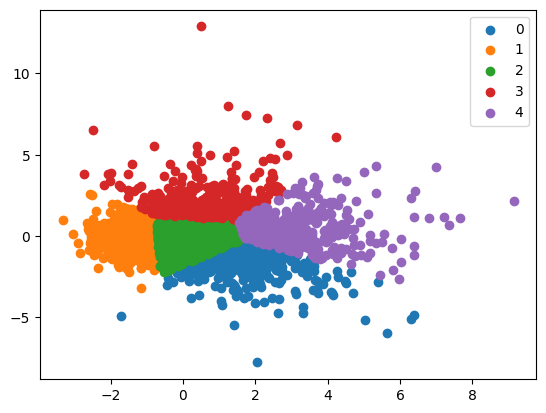

In [60]:

df = df_groceries.groupby(['Member_number', 'itemDescription']).size().unstack(fill_value=0)

# Normalizing the data
scaler = StandardScaler()
normalized_df = scaler.fit_transform(df)

# Apply PCA and keep the first two components
pca = PCA(2)
df_pca = pca.fit_transform(normalized_df)

# Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=42)  # Choose the number of clusters
clusters = kmeans.fit_predict(df_pca)

# Getting unique labels
u_labels = np.unique(clusters)

# Plotting the results:
for i in u_labels:
    plt.scatter(df_pca[clusters == i , 0] , df_pca[clusters == i , 1] , label = i)
plt.legend()
plt.show()

## **The End**